<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import ast

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)
 # quality assurance patch
geolocs = pd.read_csv('data/geolocs.csv')
balanced_corpus.lat = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[0])
balanced_corpus.lon = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[1])

balanced_corpus

,text,place,uri,collector,area,lat,lon
105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,39.650192,20.690846
8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,39.650192,20.690846
7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,39.650192,20.690846
18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,39.650192,20.690846
94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,39.650192,20.690846
...,...,...,...,...,...,...,...
101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477


In [3]:
train, test = train_test_split(balanced_corpus, 
                               test_size=0.05, 
                               random_state=2023)
train, dev = train_test_split(train, 
                              test_size=test.shape[0], 
                              random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακόν χωριόν τσα λίγα σπίτιαν')
dists.sort_values(by=0, ascending=True, axis=1)

,Asia Minor,Ioannina,Karpathos,Crete,Thesprotia,Epirus,Kefalinia,Amorgos,Eptanisos,Cyprus,...,Achaia,Arcadia,Etolia,Pontos,Skyros,East Thrace,Thrace,Maced.,Naxos,Lesvos
0,4.038577,4.313742,4.318077,4.4117,4.430579,4.492731,4.538359,4.863242,5.019258,5.063717,...,5.119214,5.133526,5.15317,5.18501,5.243022,5.250783,5.424325,5.457056,5.671837,6.209453


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Πωρνόσ στησ στράταν, τζ' ενωρίς στο κονατζιν (Κύπρος) -- predicted as: Cyprus


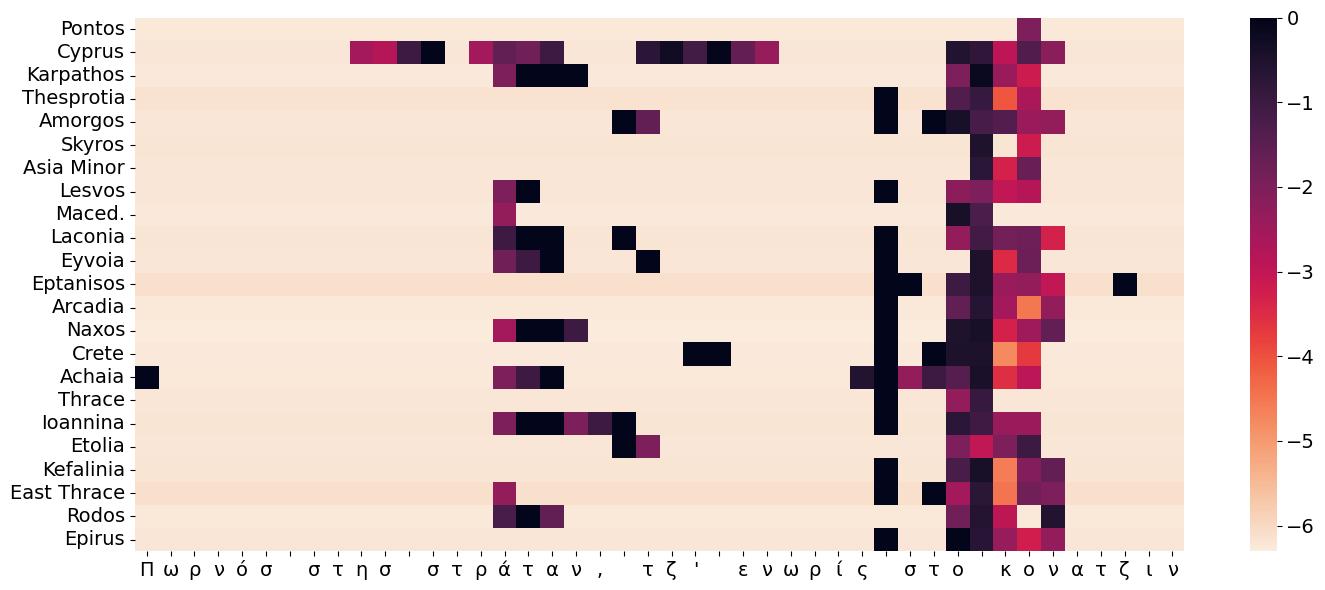

In [9]:
t = test[(test.area == "Κύπρος") & test.text.str.startswith('Πωρνό')].iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
plt.tick_params(axis='both', which='major', labelsize=14)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
ax.figure.tight_layout()
ax.figure.savefig("heatmap.pdf", format="PDF")

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

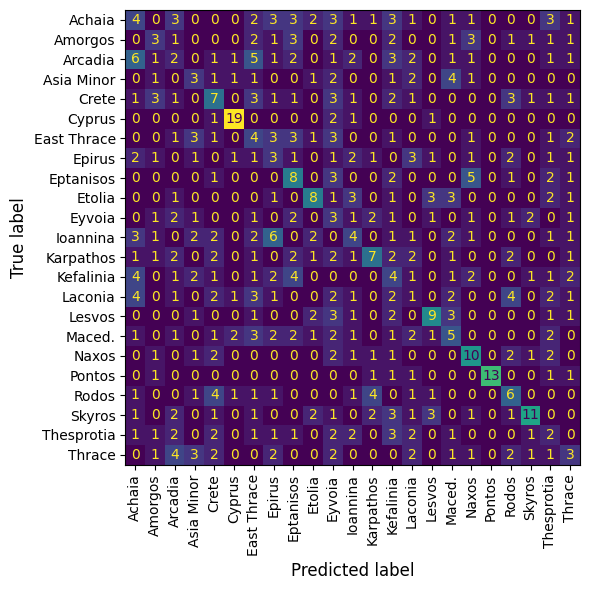

In [11]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(gold, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

## Benchmarking standard text classifiers, on top of chanracter n-grams

In [12]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
print('Vocabulary:', len(vect.vocabulary_))
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

Vocabulary: 81402
n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


### Logistic Regression

In [13]:
vect = TfidfVectorizer(ngram_range=(2, 5), 
                       analyzer="char",
                       max_df=0.5, 
                       min_df=2, lowercase=True)

regressor = LogisticRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe,
                         train.text.values,
                         train.area.values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
print(cv_score)

pipe = Pipeline([('vect', vect), ('clf', LogisticRegression())])
pipe.fit(train.text, train.area)
preds = pipe.predict(test.text)
print(f'LogisticRegression\n{classification_report(test.area.values, preds)}')

0.2859903381642512
LogisticRegression
                 precision    recall  f1-score   support

        Ήπειρος       0.17      0.17      0.17        23
        Αιτωλία       0.38      0.58      0.46        24
        Αμοργός       0.13      0.18      0.15        22
Ανατολική Θράκη       0.16      0.21      0.18        24
        Αρκαδία       0.20      0.16      0.18        31
          Αχαΐα       0.39      0.22      0.28        32
      Επτάνησος       0.35      0.65      0.45        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.05      0.05      0.05        22
          Θράκη       0.25      0.16      0.20        25
       Ιωάννινα       0.29      0.21      0.24        29
       Κάρπαθος       0.40      0.29      0.33        28
     Κεφαλληνία       0.14      0.11      0.12        27
          Κρήτη       0.35      0.27      0.30        30
         Κύπρος       0.72      0.75      0.73        24
         Λέσβος       0.42      0.62      0.50   

### SVM

In [14]:
def objective(trial):

    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    classifier = LinearSVC(C=C, penalty=penalty, dual=False, max_iter=5000)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-07 18:12:21,311] A new study created in memory with name: no-name-6db3d9ab-d12d-4ac2-84cb-2aab0a75081d
[I 2024-11-07 18:12:23,869] Trial 5 finished with value: 0.043188405797101447 and parameters: {'C': 3.943370324470401e-05, 'penalty': 'l1'}. Best is trial 5 with value: 0.043188405797101447.
[I 2024-11-07 18:12:23,892] Trial 1 finished with value: 0.043188405797101447 and parameters: {'C': 1.2392885157847114e-05, 'penalty': 'l1'}. Best is trial 5 with value: 0.043188405797101447.
[I 2024-11-07 18:12:24,824] Trial 4 finished with value: 0.0442512077294686 and parameters: {'C': 0.00010456482615597627, 'penalty': 'l1'}. Best is trial 4 with value: 0.0442512077294686.
[I 2024-11-07 18:12:26,604] Trial 2 finished with value: 0.1068599033816425 and parameters: {'C': 7.4375169807025216e-09, 'penalty': 'l2'}. Best is trial 2 with value: 0.1068599033816425.
[I 2024-11-07 18:12:26,832] Trial 0 finished with value: 0.26917874396135266 and parameters: {'C': 0.014973180938509904, 'penal

In [15]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.2947826086956522
best trial: FrozenTrial(number=85, state=1, values=[0.2947826086956522], datetime_start=datetime.datetime(2024, 11, 7, 18, 29, 25, 751332), datetime_complete=datetime.datetime(2024, 11, 7, 18, 30, 8, 18899), params={'C': 0.10349946212975641, 'penalty': 'l2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None), 'penalty': CategoricalDistribution(choices=('l1', 'l2'))}, trial_id=85, value=None)
best params: {'C': 0.10349946212975641, 'penalty': 'l2'}


In [16]:
classifier = LinearSVC(**best_params,  dual=False, max_iter=5000)
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

### KNN

In [17]:
# For some reason, scikit-learn will not always
# encode 'Ήπειρος'. This is a workaround.
from sklearn.preprocessing import LabelEncoder

area_encoded = LabelEncoder().fit_transform(train.area)

def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors,
                                      weights=weights,
                                      p=p)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             area_encoded,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-07 18:31:47,658] A new study created in memory with name: no-name-5ac81a41-0450-4331-94f8-0c784153087c
[I 2024-11-07 18:31:49,705] Trial 4 finished with value: 0.18309178743961355 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.18309178743961355.
[I 2024-11-07 18:31:52,019] Trial 3 finished with value: 0.19391304347826085 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.19391304347826085.
[I 2024-11-07 18:31:53,129] Trial 0 finished with value: 0.0442512077294686 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.19391304347826085.
[I 2024-11-07 18:31:53,427] Trial 6 finished with value: 0.19980676328502417 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 0.19980676328502417.
[I 2024-11-07 18:31:54,212] Trial 8 finished with value: 0.18309178743961355 and parameters: {'n_neighbors': 6, 'w

In [18]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.21594202898550724
best trial: FrozenTrial(number=22, state=1, values=[0.21594202898550724], datetime_start=datetime.datetime(2024, 11, 7, 18, 31, 54, 997883), datetime_complete=datetime.datetime(2024, 11, 7, 18, 32, 11, 684094), params={'n_neighbors': 50, 'weights': 'distance', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=22, value=None)
best params: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}


In [19]:
classifier = KNeighborsClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.24347826086956523

In [20]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.04      0.05        23
        Αιτωλία       0.27      0.29      0.28        24
        Αμοργός       0.21      0.27      0.24        22
Ανατολική Θράκη       0.14      0.21      0.17        24
        Αρκαδία       0.08      0.06      0.07        31
          Αχαΐα       0.21      0.19      0.20        32
      Επτάνησος       0.28      0.57      0.37        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.09      0.09      0.09        22
          Θράκη       0.19      0.12      0.15        25
       Ιωάννινα       0.13      0.07      0.09        29
       Κάρπαθος       0.33      0.21      0.26        28
     Κεφαλληνία       0.16      0.19      0.17        27
          Κρήτη       0.26      0.20      0.23        30
         Κύπρος       0.52      0.71      0.60        24
         Λέσβος       0.37      0.46      0.41        24
        Λακωνία       0.11    

In [21]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    classifier = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-07 18:33:14,983] A new study created in memory with name: no-name-66633120-bf7f-4e6e-a01b-e5d0d96f4b42
[I 2024-11-07 18:33:19,301] Trial 3 finished with value: 0.1903381642512077 and parameters: {'n_estimators': 310, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.1903381642512077.
[I 2024-11-07 18:33:21,709] Trial 0 finished with value: 0.22801932367149752 and parameters: {'n_estimators': 496, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.22801932367149752.
[I 2024-11-07 18:33:23,147] Trial 5 finished with value: 0.21420289855072464 and parameters: {'n_estimators': 249, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.22801932367149752.
[I 2024-11-07 18:33:23,501] Trial 1 finished with value: 0.24792270531400967 and parameters: {'n_estimators': 452, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with

In [22]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.24937198067632851
best trial: FrozenTrial(number=99, state=1, values=[0.24937198067632851], datetime_start=datetime.datetime(2024, 11, 7, 18, 35, 30, 62139), datetime_complete=datetime.datetime(2024, 11, 7, 18, 36, 1, 108322), params={'n_estimators': 449, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=99, value=None)
best params: {'n_estimators': 449, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [23]:
classifier = RandomForestClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.288695652173913

In [24]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.00      0.00      0.00        23
        Αιτωλία       0.30      0.67      0.42        24
        Αμοργός       0.06      0.09      0.07        22
Ανατολική Θράκη       0.12      0.17      0.14        24
        Αρκαδία       0.08      0.10      0.09        31
          Αχαΐα       0.54      0.44      0.48        32
      Επτάνησος       0.30      0.30      0.30        23
         Εύβοια       0.00      0.00      0.00        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.42      0.20      0.27        25
       Ιωάννινα       0.19      0.17      0.18        29
       Κάρπαθος       0.64      0.25      0.36        28
     Κεφαλληνία       0.17      0.15      0.16        27
          Κρήτη       0.32      0.23      0.27        30
         Κύπρος       0.48      0.83      0.61        24
         Λέσβος       0.41      0.58      0.48        24
        Λακωνία       0.17    

## Predicting the location of proverbs
* Focusing on ones which are shared in multiple locations

In [25]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",2,"[(36.76027945, 22.79046431389755), (39.6501917..."
1,"Άβολος ο νους, διπλός ο κόπος","{Νίσυρος, Μικρά Ασία>Τσεσμές (Κρήνη)}",2,"{Νίσυρος, Μικρά Ασία}",2,"[(38.1846366, 23.5122768), (36.58904575, 27.16..."
2,Άβουλος νους διπλός κόπος,"{Θήρα (Σαντορίνη), Θράκη>Αίνος}",2,"{Θήρα (Σαντορίνη), Θράκη}",2,"[(36.4071112, 25.456663652707153), (38.0105134..."
3,"Άβουλος νους, διπλός ο κόπος","{Κρήτη, Ρόδος, Αμοργός}",3,"{Κρήτη, Ρόδος, Αμοργός}",3,"[(35.308495199999996, 24.46334231842296), (36...."
4,Άβουλος ο νους διπλός ο κόπος,"{Ήπειρος>Τσαμαντάς, Ρόδος, Θράκη>Μάδυτος, Θράκ...",5,"{Σάμος, Θράκη, Ρόδος, Ήπειρος}",4,"[(36.172529749999995, 27.91940163839584), (37...."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Αργολίδα, Λέρος}",2,"[(37.9933789, 23.5389128), (37.56626615, 22.85..."
3200,πονάει το δόντι,"{Φωκίδα, Θεσσαλία>Τρίκαλα}",2,"{Θεσσαλία, Φωκίδα}",2,"[(39.5564697, 21.6905283), (38.5001712, 22.249..."
3201,"που Πάτρα, που Φλομίτσι!","{Μάνη>Αβία, Μεσσηνία>Αβία>Κάμπος}",2,"{Μάνη, Μεσσηνία}",2,"[(36.70694815, 22.122363134012744), (41.409747..."
3202,τού έδειξε τα δόντια,"{Εύβοια, Αρκαδία>Τεγέα}",2,"{Εύβοια, Αρκαδία}",2,"[(37.42908855, 22.423541964571157), (38.494172..."


In [26]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
7,Άγνεστα κι' ανύφαντα στην τέμπλα κρεμασμένα,"{Θεσσαλία, Αρκαδία>Γορτυνία}",2,"{Θεσσαλία, Αρκαδία}",Αρκαδία,2,"[(39.5564697, 21.6905283), (37.42908855, 22.42..."
2171,Ο Μανώλης με τα λόγια κτίζ' ανώγεια και κατώγεια,"{Κρήτη>Σητεία>Χαμέζι, Ιωάννινα}",2,"{Κρήτη, Ιωάννινα}",Κρήτη,2,"[(35.308495199999996, 24.46334231842296), (39...."
2139,Ξύλω τον Αδάμ κατάρας ελυτρώσω,"{Πόντος, Θράκη>Μάδυτος}",2,"{Πόντος, Θράκη}",Πόντος,2,"[(40.8909282, 25.8663242), (38.0105134, 23.732..."
2129,Ξεί τα νύχια του για καυγά,"{Αρκαδία>Γορτυνία, Αχαΐα>Καλάβρυτα}",2,"{Αχαΐα, Αρκαδία}",Αρκαδία,2,"[(38.0692748, 21.87273042232539), (37.42908855..."
2124,Ξέρ΄ η πάπια πουν΄ η λίμνη,"{Μικρά Ασία>Τσεσμές (Κρήνη), Ρόδος}",2,"{Ρόδος, Μικρά Ασία}",Μικρά Ασία,2,"[(38.1846366, 23.5122768), (36.172529749999995..."


* Showing the ones our classifier located on Cyrpus.

In [27]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
137,"Άρον, άρον","{Κύπρος, Ήπειρος}",2,"{Κύπρος, Ήπειρος}",Κύπρος,2,"[(34.9174159, 32.889902651331866), (39.6501917..."
525,"Όπου δεμ πέφτει λόγος, πέφτει ράβδος","{Νίσυρος, Κύπρος}",2,"{Νίσυρος, Κύπρος}",Κύπρος,2,"[(34.9174159, 32.889902651331866), (36.5890457..."


## Regression on the coordinates
* Instead of classifying, predicting the geographical coordinates.
* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East. 

In [28]:
optimization_results = []

In [29]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                       min_df=10, lowercase=True)

regressor = LinearRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe, 
                         train.text.values, 
                         train[["lat", "lon"]].values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
cv_score

np.float64(0.11066165692751387)

In [30]:
linear_regression_pipe = Pipeline([('vect', vect), ('reg', regressor)])
linear_regression_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = linear_regression_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.17142981802136242

In [ ]:
predicted_coords = linear_regression_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'LinearRegression', 
    cv_score, 
    score,
    None,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3804352445879466 2.804612334145914
3.003499727635002 14.697230993565798


In [32]:
def objective(trial):

    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-07 18:36:16,483] A new study created in memory with name: no-name-3f066055-051a-4d6c-942c-a02de71c6988
[I 2024-11-07 18:36:16,569] Trial 0 finished with value: 0.006374514056810299 and parameters: {'alpha': 0.03746586653874915, 'l1_ratio': 0.8619808481543767}. Best is trial 0 with value: 0.006374514056810299.
[I 2024-11-07 18:36:16,801] Trial 1 finished with value: 0.12224688029360256 and parameters: {'alpha': 0.00012794419189735335, 'l1_ratio': 0.9193536941999433}. Best is trial 1 with value: 0.12224688029360256.
[I 2024-11-07 18:36:16,928] Trial 2 finished with value: 0.13413598634429422 and parameters: {'alpha': 0.0009190868452880744, 'l1_ratio': 0.21671929251878097}. Best is trial 2 with value: 0.13413598634429422.
[I 2024-11-07 18:36:17,003] Trial 3 finished with value: -0.0003549715765302164 and parameters: {'alpha': 0.2240462973046408, 'l1_ratio': 0.6924444272337202}. Best is trial 2 with value: 0.13413598634429422.
[I 2024-11-07 18:36:17,079] Trial 4 finished with va

In [33]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.1374266882811594
best trial: FrozenTrial(number=95, state=1, values=[0.1374266882811594], datetime_start=datetime.datetime(2024, 11, 7, 18, 36, 29, 3721), datetime_complete=datetime.datetime(2024, 11, 7, 18, 36, 29, 132906), params={'alpha': 0.0005728744982858831, 'l1_ratio': 0.6723777413650661}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=95, value=None)
best params: {'alpha': 0.0005728744982858831, 'l1_ratio': 0.6723777413650661}


In [57]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,0.102869,2024-11-07 18:44:44.188091,2024-11-07 18:44:45.310411,0 days 00:00:01.122320,23,9,7,304,COMPLETE
1,1,0.099948,2024-11-07 18:44:45.310863,2024-11-07 18:44:45.958184,0 days 00:00:00.647321,23,2,7,148,COMPLETE
2,2,0.101739,2024-11-07 18:44:45.958614,2024-11-07 18:44:47.723369,0 days 00:00:01.764755,32,3,7,324,COMPLETE
3,3,0.082574,2024-11-07 18:44:47.723876,2024-11-07 18:44:47.942438,0 days 00:00:00.218562,7,3,7,122,COMPLETE
4,4,0.105611,2024-11-07 18:44:47.942879,2024-11-07 18:44:48.715645,0 days 00:00:00.772766,32,8,8,144,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,0.104837,2024-11-07 18:47:31.451904,2024-11-07 18:47:33.666172,0 days 00:00:02.214268,30,6,9,475,COMPLETE
96,96,0.106212,2024-11-07 18:47:33.666623,2024-11-07 18:47:35.878072,0 days 00:00:02.211449,32,7,9,450,COMPLETE
97,97,0.104725,2024-11-07 18:47:35.878542,2024-11-07 18:47:37.865940,0 days 00:00:01.987398,28,7,10,454,COMPLETE
98,98,0.106021,2024-11-07 18:47:37.866410,2024-11-07 18:47:40.142740,0 days 00:00:02.276330,32,7,9,440,COMPLETE


In [58]:
trials_df['value'].describe()

count    100.000000
mean       0.102615
std        0.008469
min        0.041595
25%        0.103786
50%        0.104975
75%        0.105616
max        0.106212
Name: value, dtype: float64

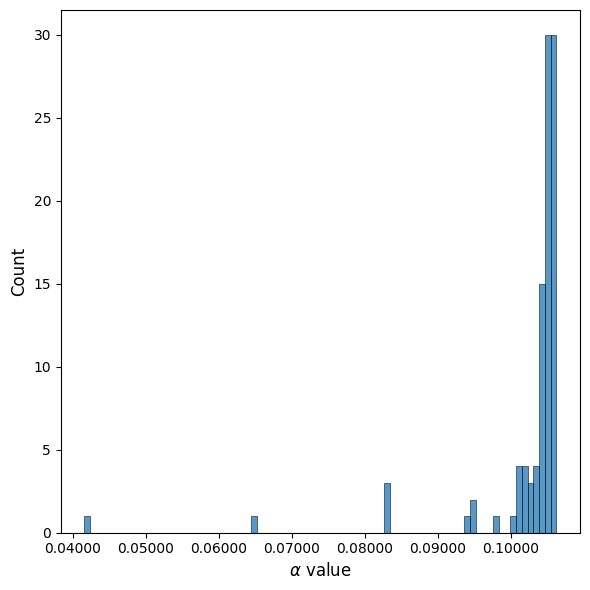

In [61]:
ax = sns.histplot(trials_df['value'])
ticks = ax.get_xticks()
ax.set_xticklabels(['{:.5f}'.format(t) for t in ticks])
ax.set_xlabel(r'$\alpha$ value')
plt.tight_layout()

In [34]:
regressor = ElasticNet(**best_params)
elastic_net_pipe = Pipeline([('vect', vect), ('reg', regressor)])
elastic_net_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = elastic_net_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.1978724831939921

In [ ]:
predicted_coords = elastic_net_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'ElasticNet', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3767949434056799 2.7790749481185775
2.9234517834423923 14.144708338867526


In [36]:
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                    weights=weights, 
                                    p=p)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-07 18:36:29,769] A new study created in memory with name: no-name-7ece3df3-0d71-4a07-9cb8-3bb5888ef59e
[I 2024-11-07 18:36:30,194] Trial 0 finished with value: -0.0032022120697871802 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: -0.0032022120697871802.
[I 2024-11-07 18:36:30,613] Trial 1 finished with value: -0.01087641592339037 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: -0.0032022120697871802.
[I 2024-11-07 18:36:31,034] Trial 2 finished with value: -0.29565367742382803 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: -0.0032022120697871802.
[I 2024-11-07 18:36:31,447] Trial 3 finished with value: 1.130079506646009e-05 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 1.130079506646009e-05.
[I 2024-11-07 18:36:31,732] Trial 4 finished with value: 0.05211730264477769 and parameters: {'

In [37]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.05683979552510965
best trial: FrozenTrial(number=21, state=1, values=[0.05683979552510965], datetime_start=datetime.datetime(2024, 11, 7, 18, 36, 40, 290259), datetime_complete=datetime.datetime(2024, 11, 7, 18, 36, 40, 518599), params={'n_neighbors': 20, 'weights': 'uniform', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=21, value=None)
best params: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}


In [38]:
regressor = KNeighborsRegressor(**best_params)
knr_pipe = Pipeline([('vect', vect), ('reg', regressor)])
knr_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = knr_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.07013869024375446

In [ ]:
predicted_coords = knr_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'KNeighborsRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.4724193533739125 3.1334937826661555
3.3419061236891396 16.64588229495783


In [40]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-07 18:37:00,744] A new study created in memory with name: no-name-f35e5170-ce0b-48ce-a8bb-92a43988e9df
[I 2024-11-07 18:37:05,257] Trial 0 finished with value: 0.10335546745265356 and parameters: {'n_estimators': 424, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.10335546745265356.
[I 2024-11-07 18:37:06,758] Trial 1 finished with value: 0.08559242466940076 and parameters: {'n_estimators': 404, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.10335546745265356.
[I 2024-11-07 18:37:08,486] Trial 2 finished with value: 0.09321353465099876 and parameters: {'n_estimators': 317, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.10335546745265356.
[I 2024-11-07 18:37:10,411] Trial 3 finished with value: 0.09593291016805451 and parameters: {'n_estimators': 294, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 wi

In [41]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.10708241360134377
best trial: FrozenTrial(number=81, state=1, values=[0.10708241360134377], datetime_start=datetime.datetime(2024, 11, 7, 18, 42, 46, 332849), datetime_complete=datetime.datetime(2024, 11, 7, 18, 42, 51, 634295), params={'n_estimators': 436, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=81, value=None)
best params: {'n_estimators': 436, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 5}


In [42]:
regressor = RandomForestRegressor(**best_params)
random_forest_pipe = Pipeline([('vect', vect), ('reg', regressor)])
random_forest_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = random_forest_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.14751523219253077

In [ ]:
predicted_coords = random_forest_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'RandomForestRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.428203323071177 2.828181662191061
3.155440724198784 14.776760420456023


In [44]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = ExtraTreesRegressor(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-07 18:44:44,187] A new study created in memory with name: no-name-66be420a-68d2-48cf-b9bf-0fe62d99248b
[I 2024-11-07 18:44:45,310] Trial 0 finished with value: 0.10286930480607323 and parameters: {'n_estimators': 304, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.10286930480607323.
[I 2024-11-07 18:44:45,958] Trial 1 finished with value: 0.09994814549933898 and parameters: {'n_estimators': 148, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.10286930480607323.
[I 2024-11-07 18:44:47,723] Trial 2 finished with value: 0.10173851066643784 and parameters: {'n_estimators': 324, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.10286930480607323.
[I 2024-11-07 18:44:47,942] Trial 3 finished with value: 0.0825743833559584 and parameters: {'n_estimators': 122, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with 

In [45]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.10621159879091971
best trial: FrozenTrial(number=96, state=1, values=[0.10621159879091971], datetime_start=datetime.datetime(2024, 11, 7, 18, 47, 33, 666623), datetime_complete=datetime.datetime(2024, 11, 7, 18, 47, 35, 878072), params={'n_estimators': 450, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=96, value=None)
best params: {'n_estimators': 450, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 7}


In [46]:
regressor = ExtraTreesRegressor(**best_params)
extra_trees_pipe = Pipeline([('vect', vect), ('reg', regressor)])
extra_trees_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = extra_trees_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.15664826443252172

In [47]:
predicted_coords = extra_trees_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'ExtraTreesRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.4297917779810605 2.8207413309708063
3.150952121244779 14.463596178389375


In [48]:
columns = [
    'regressor',
    'cv_score',
    'test_score',
    'best_params',
    'mae_lat', 
    'mae_lon',
    'mse_lat',
    'mse_lon'
]

optimization_results_df = pd.DataFrame(optimization_results, columns=columns)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon
0,LinearRegression,0.110662,0.171430,None,1.380435,2.804612,3.003500,14.697231
1,ElasticNet,0.137427,0.197872,"{'alpha': 0.0005728744982858831, 'l1_ratio': 0...",1.376795,2.779075,2.923452,14.144708
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.472419,3.133494,3.341906,16.645882
3,RandomForestRegressor,0.107082,0.147515,"{'n_estimators': 436, 'max_depth': 32, 'min_sa...",1.428203,2.828182,3.155441,14.776760
4,ExtraTreesRegressor,0.106212,0.156648,"{'n_estimators': 450, 'max_depth': 32, 'min_sa...",1.429792,2.820741,3.150952,14.463596


In [49]:
optimization_results_df['mae_avg'] = optimization_results_df[['mae_lat', 'mae_lon']].mean(axis=1)
optimization_results_df['mse_avg'] = optimization_results_df[['mse_lat', 'mse_lon']].mean(axis=1)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon,mae_avg,mse_avg
0,LinearRegression,0.110662,0.171430,None,1.380435,2.804612,3.003500,14.697231,2.092524,8.850365
1,ElasticNet,0.137427,0.197872,"{'alpha': 0.0005728744982858831, 'l1_ratio': 0...",1.376795,2.779075,2.923452,14.144708,2.077935,8.534080
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.472419,3.133494,3.341906,16.645882,2.302957,9.993894
3,RandomForestRegressor,0.107082,0.147515,"{'n_estimators': 436, 'max_depth': 32, 'min_sa...",1.428203,2.828182,3.155441,14.776760,2.128192,8.966101
4,ExtraTreesRegressor,0.106212,0.156648,"{'n_estimators': 450, 'max_depth': 32, 'min_sa...",1.429792,2.820741,3.150952,14.463596,2.125267,8.807274


In [50]:
optimization_results_df.round({
    'mae_lat':2, 
    'mae_lon': 2, 
    'mse_lat': 2, 
    'mse_lon': 2,
    'mae_avg': 2,
    'mse_avg': 2
})

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon,mae_avg,mse_avg
0,LinearRegression,0.110662,0.171430,None,1.38,2.80,3.00,14.70,2.09,8.85
1,ElasticNet,0.137427,0.197872,"{'alpha': 0.0005728744982858831, 'l1_ratio': 0...",1.38,2.78,2.92,14.14,2.08,8.53
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.47,3.13,3.34,16.65,2.30,9.99
3,RandomForestRegressor,0.107082,0.147515,"{'n_estimators': 436, 'max_depth': 32, 'min_sa...",1.43,2.83,3.16,14.78,2.13,8.97
4,ExtraTreesRegressor,0.106212,0.156648,"{'n_estimators': 450, 'max_depth': 32, 'min_sa...",1.43,2.82,3.15,14.46,2.13,8.81


* Having arrived at this point, it is worth pointing out that the $\alpha$ parameter of `ElasticNet` is very small:

In [51]:
optimization_results_df[optimization_results_df.regressor == 'ElasticNet']['best_params']

1    {'alpha': 0.0005728744982858831, 'l1_ratio': 0...
Name: best_params, dtype: object

* That means that in practice `ElasticNet` behaves pretty much like Ordinary Least Squares regression.

## Finding terms pushing North, South, West, and East

In [52]:
importance_pd = pd.DataFrame({"feature": elastic_net_pipe["vect"].get_feature_names_out(), 
                              "lat": elastic_net_pipe["reg"].coef_[0, :],
                              "lon": elastic_net_pipe["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [53]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
96,ατ,2.298668,12.217184
692,τρώγει,2.042619,-0.000000
552,πε,2.019751,-0.000000
630,σο,1.984784,11.828505
631,σον,1.746372,10.218557


### Words pushing $\downarrow$ South: lower lat

In [54]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.509779,8.752420
662,τζαι,-3.987891,8.021105
661,τζαί,-3.885801,7.809047
664,τζι,-3.264673,6.984398
226,εγιώ,-2.128995,1.775489


### Words pushing $\rightarrow$ East: higher lon

In [55]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
96,ατ,2.298668,12.217184
630,σο,1.984784,11.828505
631,σον,1.746372,10.218557
616,ση,1.619628,9.977540
660,τζ,-4.509779,8.752420


### Words pushing $\leftarrow$ West: higher lon

In [56]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
501,ου,0.682678,-4.451450
466,ναν,0.000000,-3.961451
157,γελάει,-0.000000,-3.512414
192,δεν,-0.000000,-3.359499
107,αφέντη,0.000000,-3.321322
